# K-Means e classificazione intra-cluster

## K-Means

In [ ]:
!pip install pyspark
!pip install kneed

     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 198 kB 65.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=138d60e15ad30c71454f71f422312fab4340f7a4cc1b1261fa0f356663da307c
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Spark context
from pyspark import SparkContext
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")

In [ ]:
# SQL context

from pyspark.sql import SQLContext
sqlCtx = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [ ]:
from pyspark.sql.types import FloatType
from pyspark.sql.functions import when, col, isnan, count,  regexp_replace, udf
from pyspark.sql.functions import col
from pyspark.sql.functions import when
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import BisectingKMeansModel, KMeansSummary, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from kneed import KneeLocator
from yellowbrick.cluster import KElbowVisualizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from tabulate import tabulate
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

In [ ]:
# Caricamento nuovo dataset senza missing values

filename = 'drive/MyDrive/DDAM/Australia Rain/rain_tomorrow_australia_PROVA.csv'
df_rain = sqlCtx.read.load(filename, format="csv", sep=",", inferSchema="true", header="true").drop("_c0")

Attributi con correlazione maggiore con la variabile target:
* Rainfall 0.23
* Sunshine -0.45
* WindGustSpeed 0.23
* Humidity3pm 0.44
* Pressure9am -0.24
* Cloud3pm 0.38
* RainToday

In [ ]:
df = df_rain.copy()

In [ ]:
# Seleziono colonne con correlazione maggiore di 0.15 (+ target)
df = df.select(df.RainToday, df.RainTomorrow, df.RISK_MM, df.Rainfall, 
               df.Sunshine, df.WindGustSpeed, df.Humidity3pm, df.Pressure9am, 
               df.Cloud3pm, df.Temp3pm, df.Month, df.Season)


no_cols = ['RainToday', 'RainTomorrow', 'RISK_MM', 'Month', 'Season']

cols2 = [col for col in df.columns if col not in no_cols]
for i in cols2:
  print(i)

# Drop dei null values
df = df.na.drop()

# Trasformo R.Today e R.Tomorrow in numeriche binarie
df= df.withColumn('RainToday', when( (df.RainToday == 'No'), '0' ).otherwise('1') )
df= df.withColumn('RainTomorrow', when( (df.RainTomorrow == 'No'), '0' ).otherwise('1') )

def cast_df(df):
  df_casted = df.select(*(col(c).cast("float").alias(c) if c not in ['Month', 'Season'] else col(c) for c in df.columns))

  return df_casted

#df = cast_df(df)

df = df.withColumn('RainToday' , df.RainToday.cast(IntegerType()) )
df = df.withColumn('RainTomorrow' , df.RainTomorrow.cast(IntegerType()) )

df.show(2)

Rainfall
Sunshine
WindGustSpeed
Humidity3pm
Pressure9am
Cloud3pm
Temp3pm
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+
|RainToday|RainTomorrow|RISK_MM|Rainfall|Sunshine|WindGustSpeed|Humidity3pm|Pressure9am|Cloud3pm|Temp3pm|Month|Season|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+
|        0|           0|    0.0|     0.6|     5.6|         44.0|       22.0|     1007.7|     2.0|   21.8|   12|Winter|
|        0|           0|    0.0|     0.0|     5.6|         44.0|       25.0|     1010.6|     2.0|   24.3|   12|Winter|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+
only showing top 2 rows



In [ ]:
# Creo il vettore per fare standardizzazione e clustering
# Escludo le variabili target per fare standardizzazione e clustering

assemble = VectorAssembler(inputCols=cols2, outputCol='features')
assembled_data_no_target = assemble.transform(df)

assembled_data_no_target.show(2)

+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+
|RainToday|RainTomorrow|RISK_MM|Rainfall|Sunshine|WindGustSpeed|Humidity3pm|Pressure9am|Cloud3pm|Temp3pm|Month|Season|            features|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+
|        0|           0|    0.0|     0.6|     5.6|         44.0|       22.0|     1007.7|     2.0|   21.8|   12|Winter|[0.6,5.6,44.0,22....|
|        0|           0|    0.0|     0.0|     5.6|         44.0|       25.0|     1010.6|     2.0|   24.3|   12|Winter|[0.0,5.6,44.0,25....|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+
only showing top 2 rows



In [ ]:
for attr in cols2:
  assembled_data_no_target.select([count(when(isnan(attr),True))]).show()

+----------------------------------------------+
|count(CASE WHEN isnan(Rainfall) THEN true END)|
+----------------------------------------------+
|                                             0|
+----------------------------------------------+

+----------------------------------------------+
|count(CASE WHEN isnan(Sunshine) THEN true END)|
+----------------------------------------------+
|                                             0|
+----------------------------------------------+

+---------------------------------------------------+
|count(CASE WHEN isnan(WindGustSpeed) THEN true END)|
+---------------------------------------------------+
|                                                  0|
+---------------------------------------------------+

+-------------------------------------------------+
|count(CASE WHEN isnan(Humidity3pm) THEN true END)|
+-------------------------------------------------+
|                                                0|
+----------------------------

In [ ]:
# Standard scaler
scale=StandardScaler(inputCol='features', outputCol='standardized')
data_scale=scale.fit(assembled_data_no_target)
data_scale_output=data_scale.transform(assembled_data_no_target)

In [ ]:
# Ottengo silhouette score 

silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,15):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i).setSeed(42)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("k=" + str(i)+ "--- Silhouette Score:", score)

k=2--- Silhouette Score: 0.32150598472341896
k=3--- Silhouette Score: 0.28225866021946905
k=4--- Silhouette Score: 0.27801363505899374
k=5--- Silhouette Score: 0.27849558031869315
k=6--- Silhouette Score: 0.3006109874358721
k=7--- Silhouette Score: 0.2741042369575489
k=8--- Silhouette Score: 0.2845948809170952
k=9--- Silhouette Score: 0.24638783132859668
k=10--- Silhouette Score: 0.28231872127000696
k=11--- Silhouette Score: 0.26790325048180735
k=12--- Silhouette Score: 0.2625717590858201
k=13--- Silhouette Score: 0.23912744873562264
k=14--- Silhouette Score: 0.2767207421201368


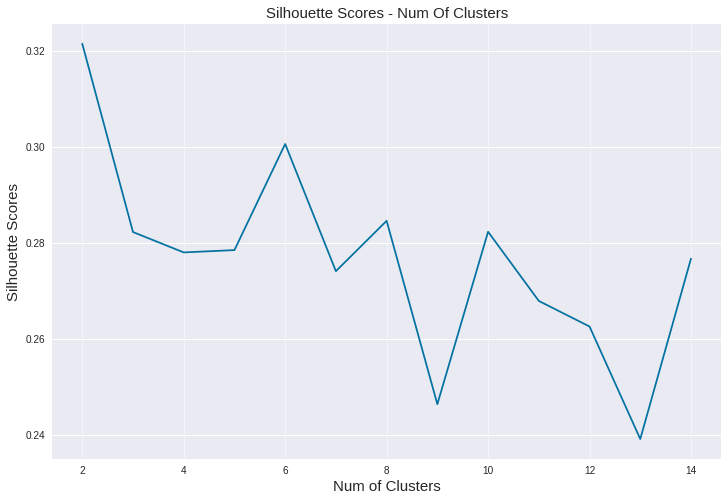

In [ ]:
# Silhouette plot
fig, ax = plt.subplots(1,1, figsize =(12, 8))
plt.style.use('seaborn-darkgrid')
ax.plot(range(2,15),silhouette_score)
ax.set_xlabel('Num of Clusters', fontsize=15)
ax.set_ylabel('Silhouette Scores', fontsize=15)
plt.title('Silhouette Scores - Num Of Clusters', fontsize=15)
plt.grid(which='both', axis='x',alpha=0.5)
plt.show()

In [ ]:
# Ottengo SSE
sse = []
for i in range(2,15):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i).setSeed(42)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    sse_i = KMeans_fit.summary.trainingCost
    sse.append(sse_i)

    print("k=" + str(i)+ "---> SSE: ", sse_i)

k=2---> SSE:  724100.9948375081
k=3---> SSE:  621145.067674594
k=4---> SSE:  568221.1852792928
k=5---> SSE:  521082.8482366548
k=6---> SSE:  464362.4212955324
k=7---> SSE:  435629.4356295067
k=8---> SSE:  415839.86236504116
k=9---> SSE:  403332.6884013031
k=10---> SSE:  375287.96548887744
k=11---> SSE:  360718.444783521
k=12---> SSE:  353519.4426445174
k=13---> SSE:  349330.2082892489
k=14---> SSE:  327352.6733398631


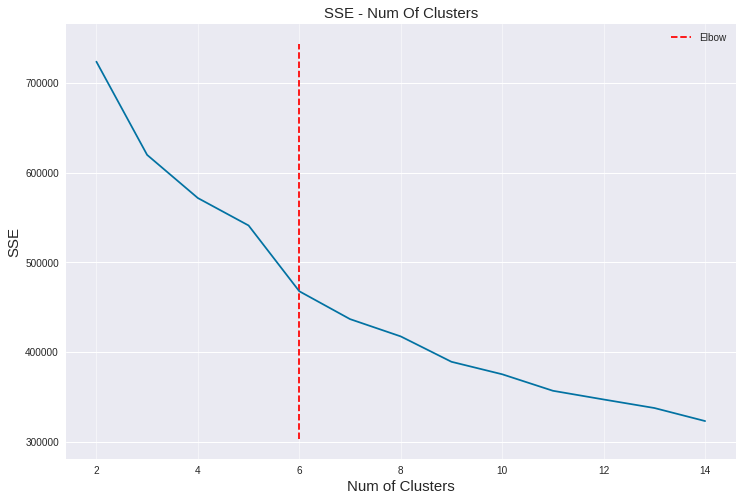

In [ ]:
# SSE plot 
kl = KneeLocator(range(2,15), sse, curve="convex", direction="decreasing")
fig, ax = plt.subplots(figsize=(12, 8))
plt.style.use('seaborn-darkgrid')
plt.plot(range(2,15), sse)
plt.xlabel('Num of Clusters', fontsize=15)
plt.ylabel('SSE', fontsize=15)
plt.title('SSE - Num Of Clusters', fontsize=15)
plt.grid(which='both', axis='x',alpha=0.5)
plt.vlines(kl.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color='red',label= "Elbow")
plt.legend(shadow=True)
plt.show()

In [ ]:
def centroids_plot(centers,feature):
  plt.figure(figsize=(30, 12))
  for i in range(0, len(centers)):
      plt.plot(centers[i], marker='o', label='Cluster %s' % i)
  plt.tick_params(axis='both', which='major', labelsize=22)
  plt.xticks(ticks = range(0, len(feature)), labels = feature)
  plt.legend(fontsize=18)
  plt.show()

In [ ]:
# K-Means con k = 6

from pyspark.ml.clustering import KMeans, KMeansModel

kmeans = KMeans().setK(6).setSeed(42)
model = kmeans.fit(data_scale_output)
centers = model.clusterCenters()
df_cluster = model.transform(assembled_data_no_target)
df_cluster = df_cluster.withColumnRenamed('prediction', 'cluster')

In [ ]:
centers

[array([5.70324738e-01, 7.53714482e+00, 3.28789092e+01, 4.21936139e+01,
        1.01988554e+03, 2.77534160e+00, 2.20450517e+01]),
 array([2.16517784e-01, 8.46089985e+00, 4.42806097e+01, 2.15236846e+01,
        1.01573088e+03, 2.48905917e+00, 2.95322816e+01]),
 array([   4.7570212 ,    4.41846587,   45.9212719 ,   84.00208308,
        1014.46657885,    5.04668546,   16.32453743]),
 array([   1.55984126,    5.96641296,   31.10845229,   63.50500503,
        1019.77678434,    3.89643428,   19.52860274]),
 array([  57.50317654,    4.12553451,   49.14416616,   76.93708002,
        1011.54074527,    5.41967013,   21.38704948]),
 array([   2.65337495,    6.45292674,   57.55690732,   52.60455685,
        1013.42809348,    3.96163492,   19.8309055 ])]

In [ ]:
df_cluster.show(2)
df_cluster.count()

+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
|RainToday|RainTomorrow|RISK_MM|Rainfall|Sunshine|WindGustSpeed|Humidity3pm|Pressure9am|Cloud3pm|Temp3pm|Month|Season|            features|cluster|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
|        0|           0|    0.0|     0.6|     5.6|         44.0|       22.0|     1007.7|     2.0|   21.8|   12|Winter|[0.6,5.6,44.0,22....|      0|
|        0|           0|    0.0|     0.0|     5.6|         44.0|       25.0|     1010.6|     2.0|   24.3|   12|Winter|[0.0,5.6,44.0,25....|      0|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
only showing top 2 rows



129852

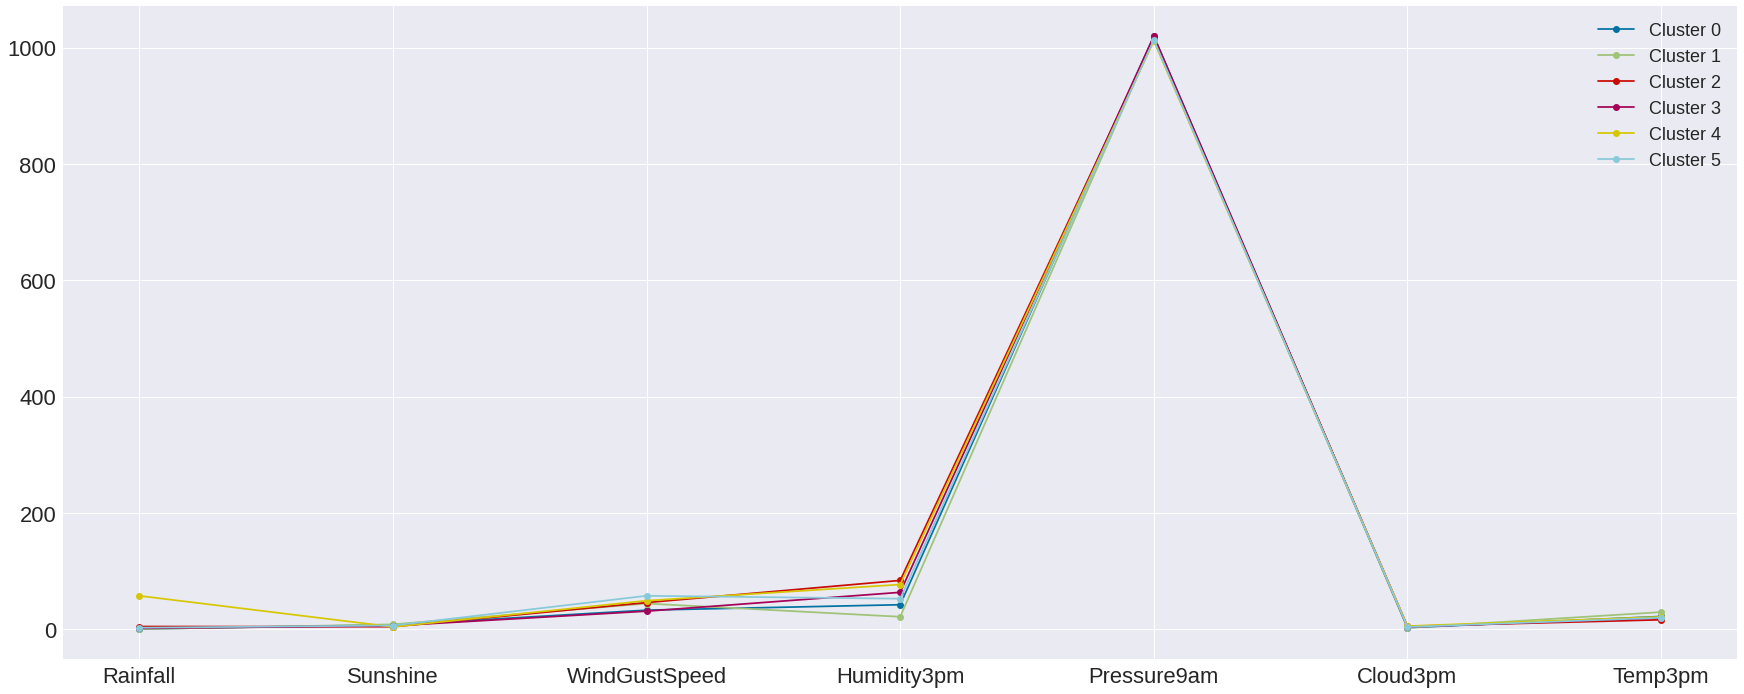

In [ ]:
centroids_plot(centers ,cols2)

In [ ]:
# Creo dataframe per ogni cluster

df0 = df_cluster.filter(df_cluster['cluster'] == 0)
df1 = df_cluster.filter(df_cluster['cluster'] == 1)
df2 = df_cluster.filter(df_cluster['cluster'] == 2)
df3 = df_cluster.filter(df_cluster['cluster'] == 3)
df4 = df_cluster.filter(df_cluster['cluster'] == 4)
df5 = df_cluster.filter(df_cluster['cluster'] == 5)

In [ ]:
df1.show(2)

+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
|RainToday|RainTomorrow|RISK_MM|Rainfall|Sunshine|WindGustSpeed|Humidity3pm|Pressure9am|Cloud3pm|Temp3pm|Month|Season|            features|cluster|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
|        0|           0|    0.0|     0.6|     5.6|         44.0|       22.0|     1007.7|     2.0|   21.8|   12|Winter|[0.6,5.6,44.0,22....|      1|
|        0|           0|    0.0|     0.0|     5.6|         44.0|       25.0|     1010.6|     2.0|   24.3|   12|Winter|[0.0,5.6,44.0,25....|      1|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
only showing top 2 rows



In [ ]:
dataframes = [df0,df1,df2,df3,df4,df5]

Attualmente i dati nella colonna 'features' non sono standardizzati. Li standardizzo e faccio la PCA per ogni cluster.

#### Analisi cluster

In [ ]:
print("**************Statistiche per variabile target ********************")
for i in range(0,6):
  print("CLUSTER " + str(i))
  dataframes[i].createOrReplaceTempView("tmp_"+str(i))
  tot = dataframes[i].count()
  print("Number of Records: ", tot)
  query = sqlCtx.sql("SELECT RainTomorrow, count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY RainTomorrow ORDER BY percentage DESC")
  query.show()

**************Statistiche per variabile target ********************
CLUSTER 0
Number of Records:  24396
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|           0| 95.5976389572061|
|           1|4.402361042793901|
+------------+-----------------+

CLUSTER 1
Number of Records:  32261
+------------+------------------+
|RainTomorrow|        percentage|
+------------+------------------+
|           0|  94.6126902451877|
|           1|5.3873097548123114|
+------------+------------------+

CLUSTER 2
Number of Records:  18024
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|           0|61.17953839325344|
|           1|38.82046160674656|
+------------+-----------------+

CLUSTER 3
Number of Records:  29699
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|           0|79.01276137243678|
|           1|20.98723862756322|
+------------+------

In [ ]:
print("**************Statistiche per variabile RainToday ********************")
for i in range(0,6):
  print("CLUSTER " + str(i))
  dataframes[i].createOrReplaceTempView("tmp_"+str(i))
  tot = dataframes[i].count()
  print("Number of Records: ", tot)
  query = sqlCtx.sql("SELECT RainToday, count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY RainToday ORDER BY percentage DESC")
  query.show()

**************Statistiche per variabile RainToday ********************
CLUSTER 0
Number of Records:  24396
+---------+-----------------+
|RainToday|       percentage|
+---------+-----------------+
|        0|96.82324971306771|
|        1|3.176750286932284|
+---------+-----------------+

CLUSTER 1
Number of Records:  32261
+---------+-----------------+
|RainToday|       percentage|
+---------+-----------------+
|        0|91.20919996280338|
|        1|8.790800037196615|
+---------+-----------------+

CLUSTER 2
Number of Records:  18024
+---------+-----------------+
|RainToday|       percentage|
+---------+-----------------+
|        0|64.93564136706613|
|        1|35.06435863293387|
+---------+-----------------+

CLUSTER 3
Number of Records:  29699
+---------+------------------+
|RainToday|        percentage|
+---------+------------------+
|        0|  74.9520185864844|
|        1|25.047981413515608|
+---------+------------------+

CLUSTER 4
Number of Records:  13428
+---------+--------

In [ ]:
print('Cluster 0')
df0.groupBy('RainTomorrow').count().show()

print('Cluster 1')
df1.groupBy('RainTomorrow').count().show()

print('Cluster 2')
df2.groupBy('RainTomorrow').count().show()

print('Cluster 3')
df3.groupBy('RainTomorrow').count().show()

print('Cluster 4')
df4.groupBy('RainTomorrow').count().show()

print('Cluster 5')
df5.groupBy('RainTomorrow').count().show()

Cluster 0
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           1| 1074|
|           0|23322|
+------------+-----+

Cluster 1
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           1| 1738|
|           0|30523|
+------------+-----+

Cluster 2
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           1| 6997|
|           0|11027|
+------------+-----+

Cluster 3
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           1| 6233|
|           0|23466|
+------------+-----+

Cluster 4
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           1| 3422|
|           0|10006|
+------------+-----+

Cluster 5
+------------+-----+
|RainTomorrow|count|
+------------+-----+
|           1| 8881|
|           0| 3163|
+------------+-----+



In [ ]:
cols_stats = ['Rainfall', 'Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure9am', 'Cloud3pm', 'Temp3pm']

In [ ]:
print("**************Statistiche su variabili categoriche********************")
for i in range(0,6):
    print("CLUSTER " + str(i))
    for j in ['Season', 'Month']:
        dataframes[i].createOrReplaceTempView("tmp_"+str(i))
        tot = dataframes[i].count()
        query = sqlCtx.sql("SELECT "+str(j)+", count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY "+ str(j) + " ORDER BY percentage DESC")
        query.show()

**************Statistiche su variabili categoriche********************
CLUSTER 0
+------+------------------+
|Season|        percentage|
+------+------------------+
|  Fall| 56.04197409411379|
|Spring|22.282341367437287|
|Winter|11.571569109690113|
|Summer|10.104115428758814|
+------+------------------+

+-----+------------------+
|Month|        percentage|
+-----+------------------+
|   01|16.137891457616004|
|   11|11.702738153795703|
|   12|11.571569109690113|
|   02|11.428102967699623|
|   03|11.264141662567633|
|   10|10.120511559272012|
|   04| 6.652729955730448|
|   09| 6.652729955730448|
|   08| 5.119691752746352|
|   05| 4.365469749139203|
|   07| 2.803738317757009|
|   06|2.1806853582554515|
+-----+------------------+

CLUSTER 1
+------+------------------+
|Season|        percentage|
+------+------------------+
|  Fall|  32.7082235516568|
|Spring|31.958091813644955|
|Summer|  30.3462384922972|
|Winter|4.9874461424010414|
+------+------------------+

+-----+------------------+

In [ ]:
print("**************Statistiche su variabili numeriche********************")
for i in range(0,6):
  print("CLUSTER " + str(i))
  for j in cols_stats:
    dataframes[i].select(j).summary().show()
  print("*****************************************************************************")

**************Statistiche su variabili numeriche********************
CLUSTER 0
+-------+------------------+
|summary|          Rainfall|
+-------+------------------+
|  count|             24396|
|   mean| 0.200135268076733|
| stddev|1.5125709427597562|
|    min|               0.0|
|    25%|               0.0|
|    50%|               0.0|
|    75%|               0.0|
|    max|              51.6|
+-------+------------------+

+-------+------------------+
|summary|          Sunshine|
+-------+------------------+
|  count|             24396|
|   mean| 8.477033120184194|
| stddev|3.0887377598724215|
|    min|               0.0|
|    25%|               5.6|
|    50%|               8.0|
|    75%|              11.3|
|    max|              14.5|
+-------+------------------+

+-------+-----------------+
|summary|    WindGustSpeed|
+-------+-----------------+
|  count|            24396|
|   mean|41.93544023610428|
| stddev|9.412235386406747|
|    min|             13.0|
|    25%|             35.0|

#### Scaling

In [ ]:
dataframes

[DataFrame[RainToday: int, RainTomorrow: int, RISK_MM: double, Rainfall: double, Sunshine: double, WindGustSpeed: double, Humidity3pm: double, Pressure9am: double, Cloud3pm: double, Temp3pm: double, Month: string, Season: string, features: vector, cluster: int],
 DataFrame[RainToday: int, RainTomorrow: int, RISK_MM: double, Rainfall: double, Sunshine: double, WindGustSpeed: double, Humidity3pm: double, Pressure9am: double, Cloud3pm: double, Temp3pm: double, Month: string, Season: string, features: vector, cluster: int],
 DataFrame[RainToday: int, RainTomorrow: int, RISK_MM: double, Rainfall: double, Sunshine: double, WindGustSpeed: double, Humidity3pm: double, Pressure9am: double, Cloud3pm: double, Temp3pm: double, Month: string, Season: string, features: vector, cluster: int],
 DataFrame[RainToday: int, RainTomorrow: int, RISK_MM: double, Rainfall: double, Sunshine: double, WindGustSpeed: double, Humidity3pm: double, Pressure9am: double, Cloud3pm: double, Temp3pm: double, Month: strin

In [ ]:
for i in range(0,5):
  dataframes[i] = dataframes[i].select(dataframes[i].RainToday, dataframes[i].RainTomorrow, dataframes[i].RISK_MM, dataframes[i].Rainfall, 
               dataframes[i].Sunshine, dataframes[i].WindGustSpeed, dataframes[i].Humidity3pm, dataframes[i].Pressure9am, 
               dataframes[i].Cloud3pm, dataframes[i].Temp3pm, dataframes[i].features, dataframes[i].cluster)

In [ ]:
scale = StandardScaler(inputCol='features', outputCol='standardized')
pca = PCA(k=3, inputCol= 'standardized', outputCol="pca")

In [ ]:
# Per fare scaling e PCA per ogni dataframe

def scaler_and_pca(dataframe):
    for dataframe in dataframes:

        data_scale = scale.fit(dataframe)
        dataframe = data_scale.transform(dataframe)

        pcamodel = pca.fit(dataframe)
        dataframe = pcamodel.transform(dataframe)

        return dataframe

In [ ]:
scaler_and_pca(dataframes)

DataFrame[RainToday: int, RainTomorrow: int, RISK_MM: double, Rainfall: double, Sunshine: double, WindGustSpeed: double, Humidity3pm: double, Pressure9am: double, Cloud3pm: double, Temp3pm: double, features: vector, cluster: int, standardized: vector, pca: vector]

In [ ]:
df2.show(2)

+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
|RainToday|RainTomorrow|RISK_MM|Rainfall|Sunshine|WindGustSpeed|Humidity3pm|Pressure9am|Cloud3pm|Temp3pm|Month|Season|            features|cluster|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
|        1|           1|   15.6|     2.2|     5.6|         31.0|       91.0|     1010.5|     8.0|   17.0|   12|Winter|[2.2,5.6,31.0,91....|      2|
|        0|           1|   16.8|     0.0|     5.6|         22.0|       82.0|     1012.2|     1.0|   18.1|   12|Winter|[0.0,5.6,22.0,82....|      2|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+-------+
only showing top 2 rows



In [ ]:
# Aggiorno con i nuovi dataframe

dataframes = [df0,df1,df2,df3,df4,df5]

## Bisecting KMeans

In [ ]:
df_bk = df_rain.copy()

In [ ]:
def getBisectingKMeans_(df, model, feature_to_scale, j, strg, plot):
  # trasformo in vector
  assembler = VectorAssembler(inputCols = feature_to_scale, outputCol="features_scale", handleInvalid = "skip")
  trasformed = assembler.transform(df)

  # applico il modello di pre-processing (MinMax, RobustScaler, PCA etc...)
  trasformedModel = model.fit(trasformed)
  trasformed = trasformedModel.transform(trasformed)

  evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
  ssh = []
  centers = []
  sse = []

  for k in range(2,j):
    # Train del modello
    bisect_kmeans = BisectingKMeans(k = k).setFeaturesCol("features").setSeed(1)
    model = bisect_kmeans.fit(trasformed)

    # Transform
    predictions = model.transform(trasformed)

    # Valutazione del Cluster mediante Silhouette score
    ssh.append(evaluator.evaluate(predictions))

    # Valutazione del Cluster mediante SSE
    sse.append(model.summary.trainingCost)

    # Cluster centroidi
    centers.append(model.clusterCenters())
  if plot:
    print(strg)
    print("Plot con le features: " )
    for i in feature_to_scale:
      print(i, end= " ")
      
    # SSE plot 
    kl = KneeLocator(range(2,j), sse, curve="convex", direction="decreasing")
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.style.use('seaborn-darkgrid')
    plt.plot(range(2,j), sse)
    plt.xlabel('Num of Clusters', fontsize=15)
    plt.ylabel('SSE', fontsize=15)
    plt.title('SSE - Num Of Clusters', fontsize=15)
    plt.grid(which='both', axis='x',alpha=0.5)
    plt.vlines(kl.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color='red',label= "Elbow")
    plt.legend(shadow=True)
    plt.show()

    # Silhouette plot
    fig, ax = plt.subplots(1,1, figsize =(12, 8))
    plt.style.use('seaborn-darkgrid')
    ax.plot(range(2,j),ssh)
    ax.set_xlabel('Num of Clusters', fontsize=15)
    ax.set_ylabel('Silhouette Scores', fontsize=15)
    plt.title('Silhouette Scores - Num Of Clusters', fontsize=15)
    plt.grid(which='both', axis='x',alpha=0.5)
    plt.show()

  for i in range(0,j-2):
    print( 'k = ' + str(i)  + '||  SSE = ' '{:.2f}'.format(sse[i]) + '|| Silhouette Score = ' + str(ssh[i]) )
  return centers, ssh, sse

Tutto il Dataset
Plot con le features: 
Rainfall Sunshine WindGustSpeed Temp3pm Humidity3pm Pressure9am Cloud3pm 

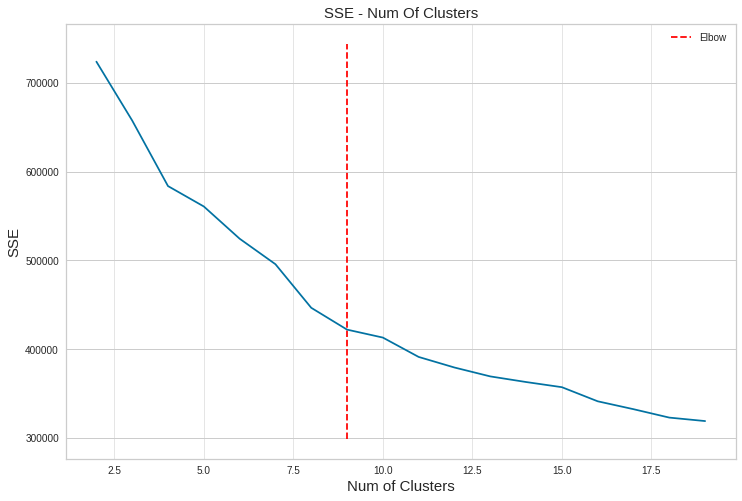

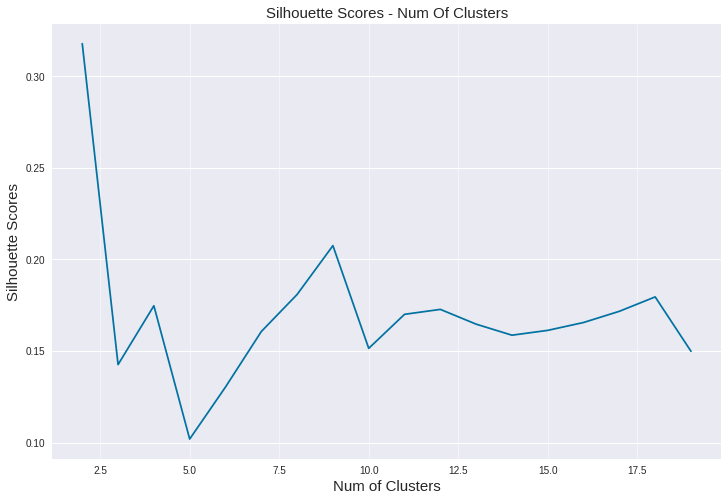

k = 0||  SSE = 723860.46|| Silhouette Score = 0.3177598022141618
k = 1||  SSE = 657548.69|| Silhouette Score = 0.14262584179460577
k = 2||  SSE = 583756.05|| Silhouette Score = 0.17473460394240853
k = 3||  SSE = 560796.30|| Silhouette Score = 0.10200337832251702
k = 4||  SSE = 524514.46|| Silhouette Score = 0.13038176180388125
k = 5||  SSE = 495787.50|| Silhouette Score = 0.16066686772570077
k = 6||  SSE = 446698.82|| Silhouette Score = 0.1808950530373716
k = 7||  SSE = 422117.64|| Silhouette Score = 0.20754043207632747
k = 8||  SSE = 413160.42|| Silhouette Score = 0.15148856579545278
k = 9||  SSE = 391354.45|| Silhouette Score = 0.17006219437142128
k = 10||  SSE = 379445.73|| Silhouette Score = 0.17275763018205909
k = 11||  SSE = 369435.94|| Silhouette Score = 0.16469463573092327
k = 12||  SSE = 363104.74|| Silhouette Score = 0.1586713278753193
k = 13||  SSE = 357295.91|| Silhouette Score = 0.161312248456212
k = 14||  SSE = 341408.34|| Silhouette Score = 0.16560320232021417
k = 15||  

In [ ]:
feature_to_scale = ['Rainfall', 'Sunshine', 'WindGustSpeed', 'Temp3pm', 'Humidity3pm', 'Pressure9am', 'Cloud3pm']
strg =  "Tutto il Dataset"
model = StandardScaler(inputCol="features_scale", outputCol="features")
centers, ssh, sse = getBisectingKMeans_(df_bk, model, feature_to_scale, 20, strg, True)

In [ ]:
# trasformo in vector
assembler = VectorAssembler(inputCols = feature_to_scale, outputCol="features_scale", handleInvalid = "skip")
transformed = assembler.transform(df_bk)

# applico il modello di pre-processing (MinMax, RobustScaler, PCA etc...)
trasformedModel = model.fit(trasformed)
transformed = trasformedModel.transform(trasformed)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                              metricName='silhouette', distanceMeasure='squaredEuclidean')

In [ ]:
kmeans = BisectingKMeans(k=8, seed=1)
bisecting_K = kmeans.fit(transformed)

In [ ]:
predictions = bisecting_K.transform(transformed)
predictions.show()

+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+--------------------+----------+
|RainToday|RainTomorrow|RISK_MM|Rainfall|Sunshine|WindGustSpeed|Humidity3pm|Pressure9am|Cloud3pm|Temp3pm|Month|Season|      features_scale|            features|prediction|
+---------+------------+-------+--------+--------+-------------+-----------+-----------+--------+-------+-----+------+--------------------+--------------------+----------+
|        0|           0|    0.0|     0.6|     5.6|         44.0|       22.0|     1007.7|     2.0|   21.8|   12|Winter|[0.6,5.6,44.0,21....|[0.07183158520680...|         2|
|        0|           0|    0.0|     0.0|     5.6|         44.0|       25.0|     1010.6|     2.0|   24.3|   12|Winter|[0.0,5.6,44.0,24....|[0.0,1.8967469831...|         2|
|        0|           0|    0.0|     0.0|     5.6|         46.0|       30.0|     1007.6|     2.0|   23.2|   12|Winter|[0.0,5.6,46.0,23....|[

In [ ]:
# Creo dataframe per ogni cluster
df0_bk = predictions.filter(predictions['prediction'] == 0)
df1_bk = predictions.filter(predictions['prediction'] == 1)
df2_bk = predictions.filter(predictions['prediction'] == 2)
df3_bk = predictions.filter(predictions['prediction'] == 3)
df4_bk = predictions.filter(predictions['prediction'] == 4)
df5_bk = predictions.filter(predictions['prediction'] == 5)

In [ ]:
dataframes_bk = [df0_bk,df1_bk,df2_bk,df3_bk,df4_bk,df5_bk]

In [ ]:
print("**************Statistiche per variabile RainToday ********************")
for i in range(0,6):
  print("CLUSTER " + str(i))
  dataframes_bk[i].createOrReplaceTempView("tmp_"+str(i))
  tot = dataframes_bk[i].count()
  print("Number of Records: ", tot)
  query = sqlCtx.sql("SELECT RainToday, count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY RainToday ORDER BY percentage DESC")
  query.show()

**************Statistiche per variabile RainToday ********************
CLUSTER 0
Number of Records:  20908
+---------+-----------------+
|RainToday|       percentage|
+---------+-----------------+
|        0|92.72048976468338|
|        1|7.279510235316625|
+---------+-----------------+

CLUSTER 1
Number of Records:  16298
+---------+-----------------+
|RainToday|       percentage|
+---------+-----------------+
|        0|92.23831144925758|
|        1|7.761688550742423|
+---------+-----------------+

CLUSTER 2
Number of Records:  24359
+---------+------------------+
|RainToday|        percentage|
+---------+------------------+
|        0| 92.11790303378628|
|        1|7.8820969662137195|
+---------+------------------+

CLUSTER 3
Number of Records:  8705
+---------+------------------+
|RainToday|        percentage|
+---------+------------------+
|        0| 89.02929350947731|
|        1|10.970706490522689|
+---------+------------------+

CLUSTER 4
Number of Records:  19184
+---------+---

In [ ]:
print("**************Statistiche per variabile target ********************")
for i in range(0,6):
  print("CLUSTER " + str(i))
  dataframes_bk[i].createOrReplaceTempView("tmp_"+str(i))
  tot = dataframes_bk[i].count()
  print("Number of Records: ", tot)
  query = sqlCtx.sql("SELECT RainTomorrow, count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY RainTomorrow ORDER BY percentage DESC")
  query.show()

**************Statistiche per variabile target ********************
CLUSTER 0
Number of Records:  20908
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|           0|93.40922135067916|
|           1|6.590778649320835|
+------------+-----------------+

CLUSTER 1
Number of Records:  16298
+------------+------------------+
|RainTomorrow|        percentage|
+------------+------------------+
|           0| 96.55172413793103|
|           1|3.4482758620689653|
+------------+------------------+

CLUSTER 2
Number of Records:  24359
+------------+-----------------+
|RainTomorrow|       percentage|
+------------+-----------------+
|           0|91.91674535079437|
|           1|8.083254649205632|
+------------+-----------------+

CLUSTER 3
Number of Records:  8705
+------------+------------------+
|RainTomorrow|        percentage|
+------------+------------------+
|           0| 83.96323951751867|
|           1|16.036760482481334|
+------------+--

In [ ]:
print("**************Statistiche su variabili categoriche********************")
for i in range(0,6):
    print("CLUSTER " + str(i))
    for j in ['Season', 'Month']:
        dataframes_bk[i].createOrReplaceTempView("tmp_"+str(i))
        tot = dataframes_bk[i].count()
        query = sqlCtx.sql("SELECT "+str(j)+", count(*)/"+str(tot)+" * 100 as percentage FROM tmp_"+str(i)+" GROUP BY "+ str(j) + " ORDER BY percentage DESC")
        query.show()

**************Statistiche su variabili categoriche********************
CLUSTER 0
+------+------------------+
|Season|        percentage|
+------+------------------+
|  Fall| 37.30629424143868|
|Spring| 35.69447101587909|
|Summer|20.700210445762387|
|Winter| 6.299024296919839|
+------+------------------+

+-----+------------------+
|Month|        percentage|
+-----+------------------+
|   04| 12.37803711497991|
|   05|11.794528410177922|
|   03|11.521905490721256|
|   10|  9.01568777501435|
|   08| 8.016070403673234|
|   09| 7.604744595370192|
|   11| 7.107327338817678|
|   02| 7.011670174096039|
|   06|6.5716472163765065|
|   01| 6.566864358140425|
|   12| 6.299024296919839|
|   07| 6.112492825712646|
+-----+------------------+

CLUSTER 1
+------+------------------+
|Season|        percentage|
+------+------------------+
|  Fall| 36.99840471223463|
|Summer|29.396244938029202|
|Spring|29.126273162351207|
|Winter| 4.479077187384956|
+------+------------------+

+-----+------------------+

In [ ]:
print("**************Statistiche su variabili numeriche********************")
for i in range(0,6):
  print("CLUSTER " + str(i))
  for j in feature_to_scale:
    dataframes_bk[i].select(j).summary().show()
  print("*****************************************************************************")

**************Statistiche su variabili numeriche********************
CLUSTER 0
+-------+-------------------+
|summary|           Rainfall|
+-------+-------------------+
|  count|              20908|
|   mean|0.36930361584082166|
| stddev| 1.6353756410622176|
|    min|                0.0|
|    25%|                0.0|
|    50%|                0.0|
|    75%|                0.0|
|    max|               35.6|
+-------+-------------------+

+-------+------------------+
|summary|          Sunshine|
+-------+------------------+
|  count|             20908|
|   mean| 5.749856514252518|
| stddev|0.6178252340104854|
|    min|               0.0|
|    25%|               5.6|
|    50%|               5.6|
|    75%|               5.6|
|    max|               9.5|
+-------+------------------+

+-------+-----------------+
|summary|    WindGustSpeed|
+-------+-----------------+
|  count|            20908|
|   mean|33.28104074995217|
| stddev|9.023787287193201|
|    min|              7.0|
|    25%|      

## Classificazione

### Decision Tree

In [ ]:
# DT con 'pca' come input column
dt = DecisionTreeClassifier(featuresCol = 'pca', labelCol = 'RainTomorrow', seed= 42)

# grid search
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [  x for x in range( 2, 15, 3 )   ]) \
    .build()

# cross-validation
crossval = CrossValidator(estimator=dt,
                          numFolds= 5,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(labelCol='RainTomorrow',
                                                                   rawPredictionCol='prediction',
                                                                   metricName="areaUnderROC"))

# Evaluator per ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='RainTomorrow',
                                                metricName="areaUnderROC")

# Evaluator per PR curve
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='RainTomorrow',
                                                metricName="areaUnderPR")

In [ ]:
def alberoDecisionale(dataframe, cluster):

    splits = dataframe.randomSplit([0.7, 0.3])    
    train = splits[0]      
    test = splits[1]

    cvModel = crossval.fit(train)
    bestModel = cvModel.bestModel
    predictions = bestModel.transform(test)
    #dtmodel = crossval.fit(train)
    #predictions = dtmodel.transform(test)

    print()
    #print('----- Cluster {} -----'.format(cluster))
    # Area under ROC curve
    #print('Area under ROC curve:', evaluator.evaluate(predictions))
    
    # Area under PR curve
    #print('Area under PR curve: ', evaluator2.evaluate(predictions))

    TP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['RainTomorrow'] == 1)).count() +0.1 # evita ZeroDivisionError
    FP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['RainTomorrow'] == 0)).count()
    TN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['RainTomorrow'] == 0)).count()
    FN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['RainTomorrow'] == 1)).count()

    '''print('Accuracy:', (TP+TN)/(TP+TN+FP+FN))
    print('Precision:', TP/(TP+FP))
    print('Recall:', TP/(TP+FN))
    print('F-measure:', (2*TP)/(2*TP+FN+FP))'''

    print(tabulate([['Area under ROC curve:', evaluator.evaluate(predictions)],
                    ['Area under PR curve:', evaluator2.evaluate(predictions)],
                    ['Accuracy:', (TP+TN)/(TP+TN+FP+FN)], 
                    ['Precision:', TP/(TP+FP)], 
                    ['Recall:', TP/(TP+FN)], 
                    ['F-measure:', (2*TP)/(2*TP+FN+FP)]], headers=['Cluster {}'.format(cluster), ''], tablefmt='orgtbl'))

In [ ]:
print('+-------------+')
print('|Decision Tree|')
print('+-------------+')


c = 0
for dataframe in dataframes:
    alberoDecisionale(dataframe, c)
    c += 1

+-------------+
|Decision Tree|
+-------------+

| Cluster 0             |           |
|-----------------------+-----------|
| Area under ROC curve: | 0.533439  |
| Area under PR curve:  | 0.108102  |
| Accuracy:             | 0.941267  |
| Precision:            | 0.163155  |
| Recall:               | 0.0873912 |
| F-measure:            | 0.113818  |

| Cluster 1             |           |
|-----------------------+-----------|
| Area under ROC curve: | 0.510533  |
| Area under PR curve:  | 0.0854266 |
| Accuracy:             | 0.931802  |
| Precision:            | 0.114792  |
| Recall:               | 0.0381332 |
| F-measure:            | 0.0572486 |

| Cluster 2             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.700221 |
| Area under PR curve:  | 0.607532 |
| Accuracy:             | 0.728571 |
| Precision:            | 0.667427 |
| Recall:               | 0.579451 |
| F-measure:            | 0.620335 |

| Cluster 3             |          |
|------

### Random Forest

In [ ]:
rf = RandomForestClassifier(featuresCol = 'pca', labelCol = 'RainTomorrow', seed= 42)

# grid search
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [  x for x in range( 2, 15, 3 )   ]) \
    .addGrid(rf.numTrees, [  x for x in range( 2, 15, 3 )   ]) \
    .build()

# cross-validation
crossval = CrossValidator(estimator=rf,
                          numFolds= 5,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(labelCol='RainTomorrow',
                                                                   rawPredictionCol='prediction',
                                                                   metricName="areaUnderROC"))

# Evaluator per ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='RainTomorrow',
                                                metricName="areaUnderROC")

# Evaluator per PR curve
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='RainTomorrow',
                                                metricName="areaUnderPR")

In [ ]:
def forestaCasuale(dataframe, cluster):
    splits = dataframe.randomSplit([0.7, 0.3])    
    train = splits[0]      
    test = splits[1] 

    rfmodel= rf.fit(train)
    predictions = rfmodel.transform(test)

    print()

    TP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['RainTomorrow'] == 1)).count() +0.1 # evita ZeroDivisionError
    FP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['RainTomorrow'] == 0)).count()
    TN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['RainTomorrow'] == 0)).count()
    FN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['RainTomorrow'] == 1)).count()

    print(tabulate([['Area under ROC curve:', evaluator.evaluate(predictions)],
                    ['Area under PR curve:', evaluator2.evaluate(predictions)],
                    ['Accuracy:', (TP+TN)/(TP+TN+FP+FN)], 
                    ['Precision:', TP/(TP+FP)], 
                    ['Recall:', TP/(TP+FN)], 
                    ['F-measure:', (2*TP)/(2*TP+FN+FP)]], headers=['Cluster {}'.format(cluster), ''], tablefmt='orgtbl'))

In [ ]:
print('+-------------+')
print('|Random Forest|')
print('+-------------+')


c = 0
for dataframe in dataframes:
    forestaCasuale(dataframe, c)
    c += 1

+-------------+
|Random Forest|
+-------------+

| Cluster 0             |             |
|-----------------------+-------------|
| Area under ROC curve: | 0.5         |
| Area under PR curve:  | 0.0433142   |
| Accuracy:             | 0.956686    |
| Precision:            | 1           |
| Recall:               | 0.000322477 |
| F-measure:            | 0.000644745 |

| Cluster 1             |             |
|-----------------------+-------------|
| Area under ROC curve: | 0.5         |
| Area under PR curve:  | 0.0557035   |
| Accuracy:             | 0.944297    |
| Precision:            | 1           |
| Recall:               | 0.000191168 |
| F-measure:            | 0.000382263 |

| Cluster 2             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.70125  |
| Area under PR curve:  | 0.626258 |
| Accuracy:             | 0.731104 |
| Precision:            | 0.691787 |
| Recall:               | 0.564038 |
| F-measure:            | 0.621415 |

| Cluster 3 

### Logistic Regression

In [ ]:
lr = LogisticRegression(featuresCol = 'pca', labelCol = 'RainTomorrow')

# grid search
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [x for x in range(1,30,5)])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# cross-validation
crossval = CrossValidator(estimator=lr,
                          numFolds= 5,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(labelCol='RainTomorrow',
                                                                   rawPredictionCol='prediction',
                                                                   metricName="areaUnderROC"))

# Evaluator per ROC curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='RainTomorrow',
                                                metricName="areaUnderROC")

# Evaluator per PR curve
evaluator2 = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                                labelCol='RainTomorrow',
                                                metricName="areaUnderPR")

In [ ]:
def regressioneLogistica(dataframe, cluster):
    splits = dataframe.randomSplit([0.7, 0.3])    
    train = splits[0]      
    test = splits[1] 

    lrmodel= crossval.fit(train)
    predictions = lrmodel.transform(test)

    print()

    TP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['RainTomorrow'] == 1)).count() +0.1 # evita ZeroDivisionError
    FP = predictions.filter((predictions['prediction'] == 1.0) & (predictions['RainTomorrow'] == 0)).count()
    TN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['RainTomorrow'] == 0)).count()
    FN = predictions.filter((predictions['prediction'] == 0.0) & (predictions['RainTomorrow'] == 1)).count()

    print(tabulate([['Area under ROC curve:', evaluator.evaluate(predictions)],
                    ['Area under PR curve:', evaluator2.evaluate(predictions)],
                    ['Accuracy:', (TP+TN)/(TP+TN+FP+FN)], 
                    ['Precision:', TP/(TP+FP)], 
                    ['Recall:', TP/(TP+FN)], 
                    ['F-measure:', (2*TP)/(2*TP+FN+FP)]], headers=['Cluster {}'.format(cluster), ''], tablefmt='orgtbl'))

In [ ]:
print('+-------------------+')
print('|Logistic Regression|')
print('+-------------------+')

c = 0
for dataframe in dataframes:
    regressioneLogistica(dataframe, c)
    c += 1

+-------------------+
|Logistic Regression|
+-------------------+

| Cluster 0             |            |
|-----------------------+------------|
| Area under ROC curve: | 0.501156   |
| Area under PR curve:  | 0.105919   |
| Accuracy:             | 0.954657   |
| Precision:            | 0.180328   |
| Recall:               | 0.00332226 |
| F-measure:            | 0.00652432 |

| Cluster 1             |             |
|-----------------------+-------------|
| Area under ROC curve: | 0.5         |
| Area under PR curve:  | 0.0575457   |
| Accuracy:             | 0.942455    |
| Precision:            | 1           |
| Recall:               | 0.000181455 |
| F-measure:            | 0.000362845 |

| Cluster 2             |          |
|-----------------------+----------|
| Area under ROC curve: | 0.6895   |
| Area under PR curve:  | 0.590197 |
| Accuracy:             | 0.713734 |
| Precision:            | 0.643862 |
| Recall:               | 0.582353 |
| F-measure:            | 0.611565 |

| 